In [135]:
import pandas as pd
import numpy as np
import glob, pickle
import matplotlib.pyplot as plt
import seaborn as sns

# Load train set on cesium format
cs_ = glob.glob('../data/training_cesium_curves/*.pkl')
oids_ = glob.glob('../data/training_cesium_curves/*.npy')

ts_a = []
ms_a = []
es_a = []
ds_a = []
oids_a = []

for c_, o_ in zip(cs_, oids_):
    with open(c_, 'rb') as fp:
        full_c=pickle.load(fp)
    oids_a.append(np.load(o_))
    ts_a.extend(full_c[0])
    ms_a.extend(full_c[1])
    es_a.extend(full_c[2])
    ds_a.extend(full_c[3])
oids_a = np.hstack(oids_a)

# Load metadata and target/pred info
meta = pd.read_hdf('../data/train_oof.h5')

In [113]:
#meta[['object_id', 'hostgal_photoz']].to_hdf('../data/train_rs.h5', key='wb')

In [145]:
# Class freqs
meta['pred'].value_counts()#.iloc[[0,1,5,8,9]]
meta.groupby('target')['hostgal_photoz'].std()

target
6     0.000000
15    0.554357
16    0.000000
42    0.636974
52    0.523921
53    0.000000
62    0.643636
64    0.737210
65    0.000000
67    0.701570
88    0.621147
90    0.464670
92    0.000000
95    0.495689
Name: hostgal_photoz, dtype: float64

<Figure size 432x288 with 0 Axes>

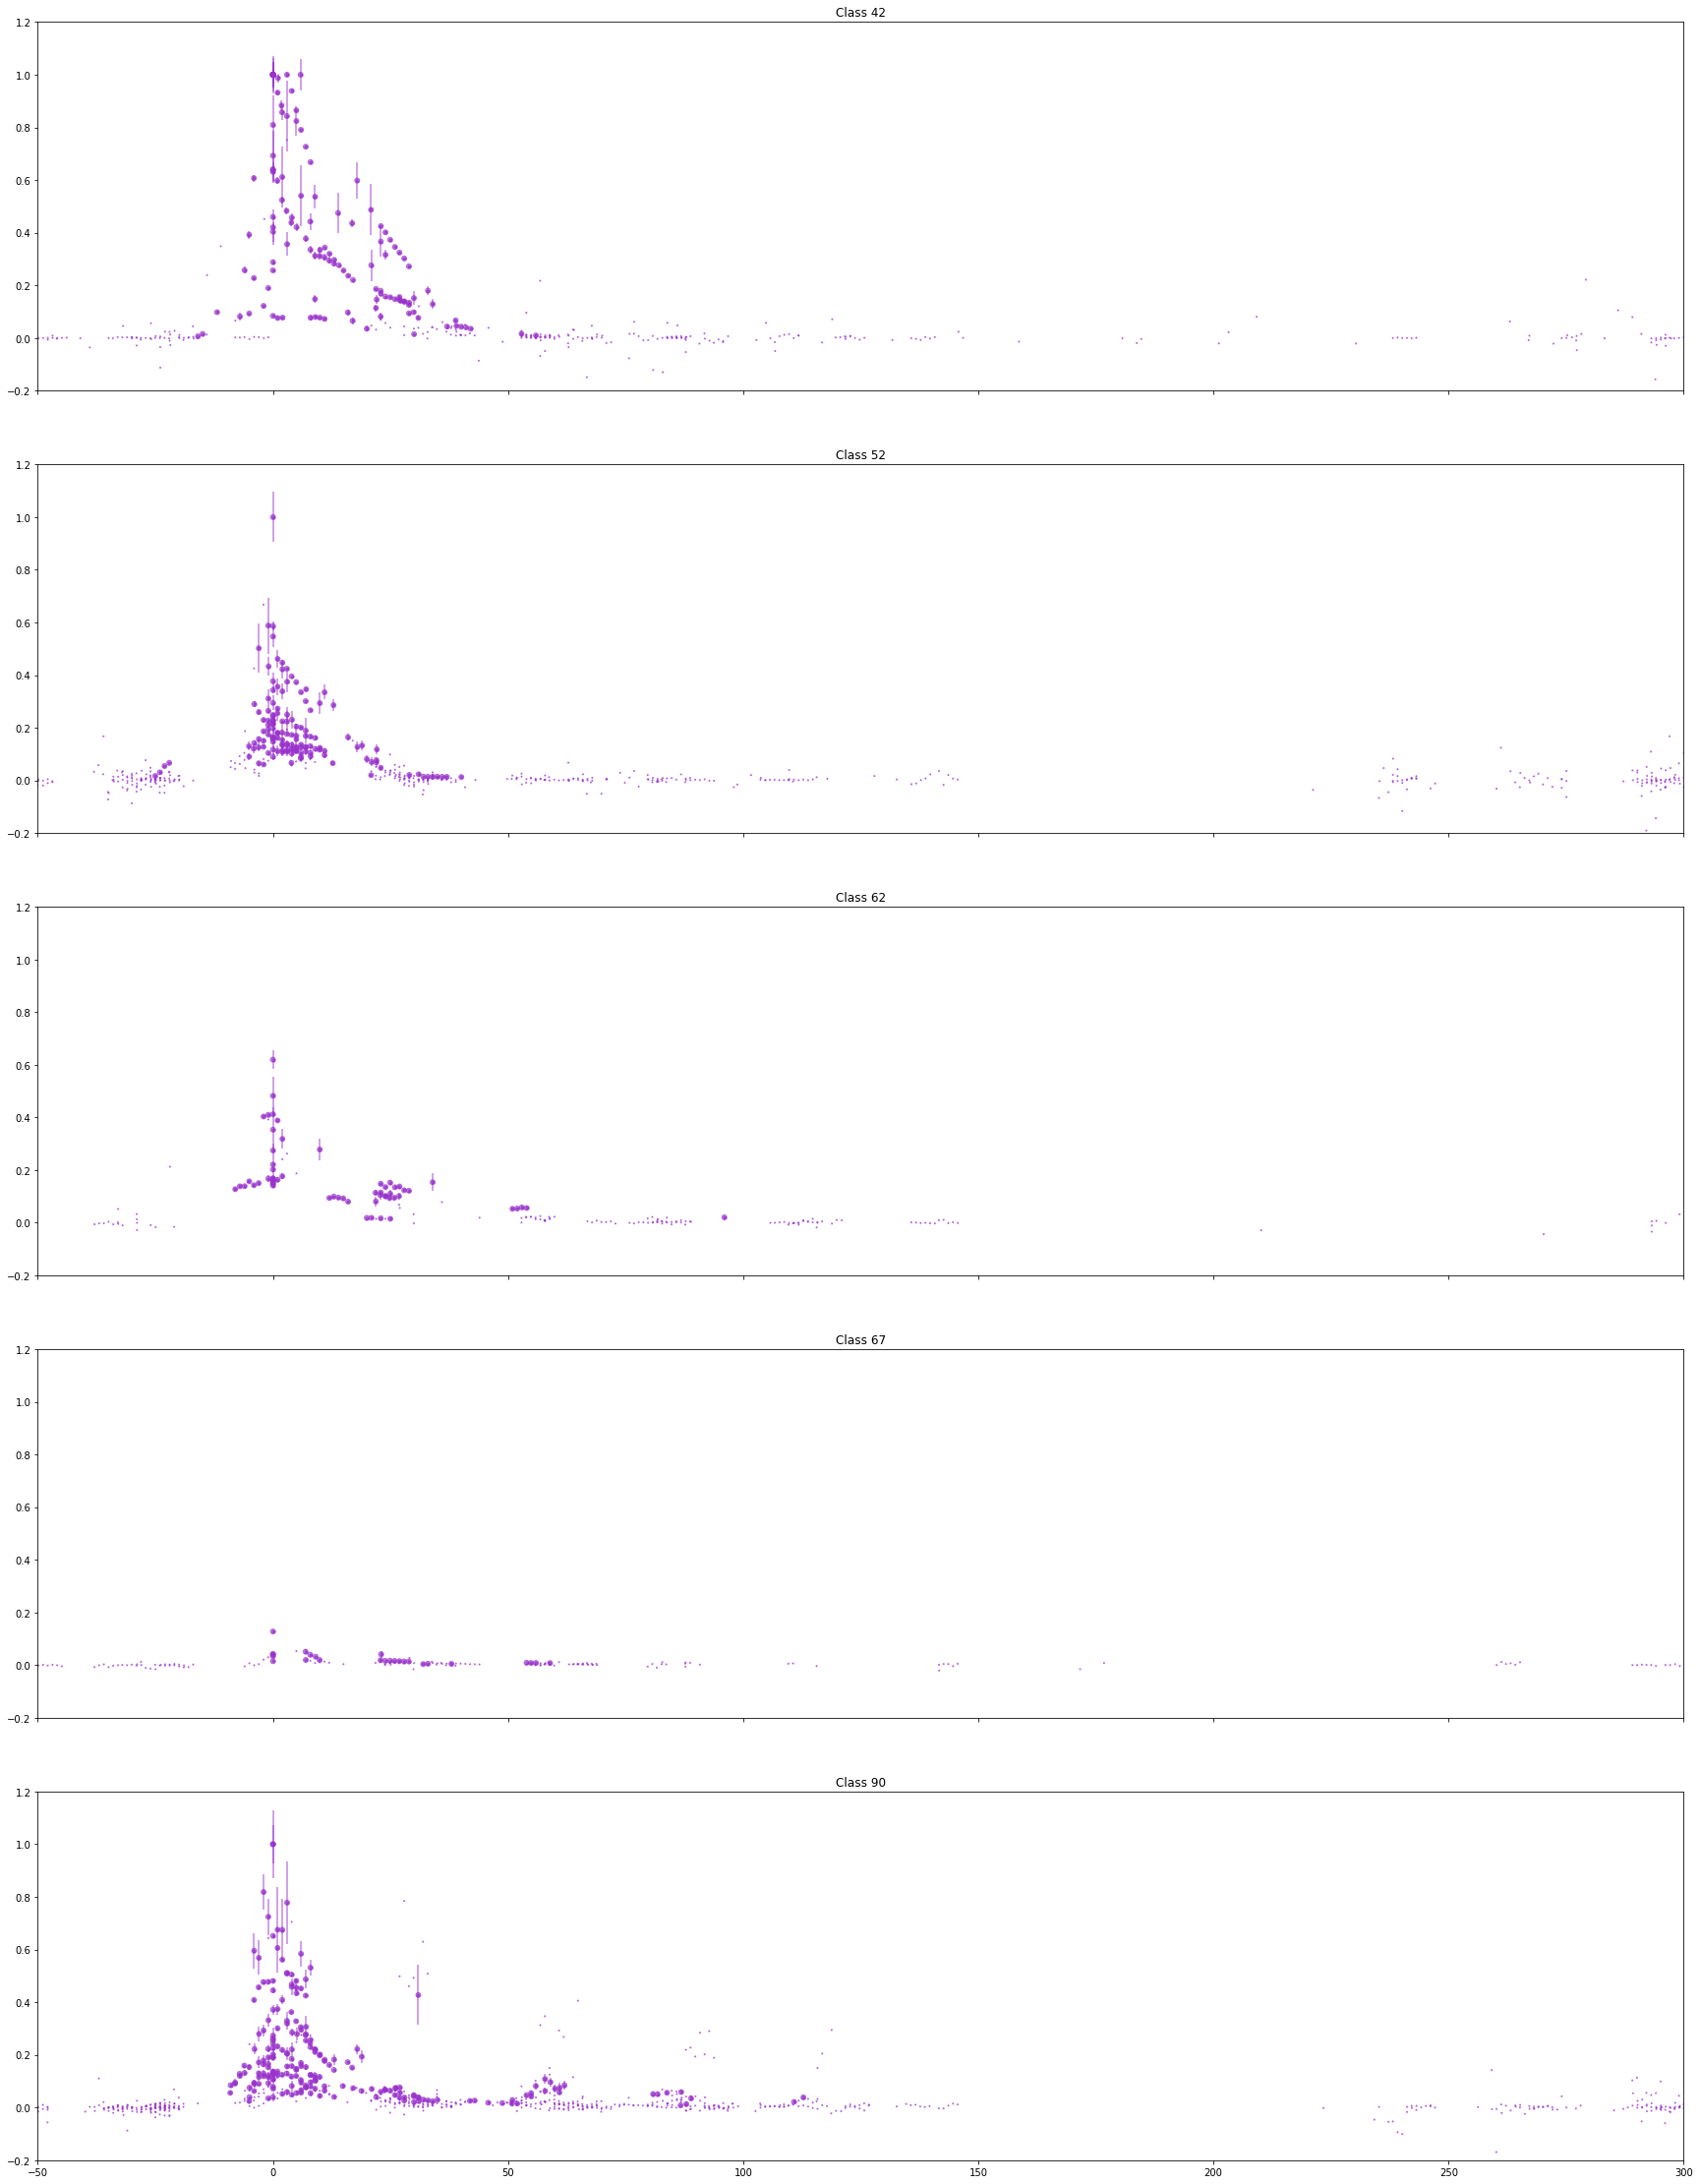

In [123]:
'''
ENSEMBLE BANDS, ALL CLASSES
'''

# Select sn class
sn_classs = [42, 52, 62, 67, 90]

# Plt confs
plt.close('all')
plt.cla()
plt.clf()

f, axs = plt.subplots(5, 1, sharex=True, sharey=True, figsize=(30,8*5))
colors = ['darkorchid', 'royalblue', 'forestgreen', 'orange', 'indianred', 'peru']
MAX_C=183

for j, sn_class in enumerate(sn_classs):
    
    sn_oids = meta.loc[meta['target']==sn_class,'object_id'].values
    mask = np.arange(0, len(ts_a))[np.isin(oids_a, sn_oids)]
    ts = [ts_a[i] for i in mask]
    ms = [ms_a[i] for i in mask]
    es = [es_a[i] for i in mask]
    ds = [ds_a[i] for i in mask]
    oids = oids_a[mask]

    #axs[j].set_yscale('log')
    for tt, mm, ee, dd, oidd in zip(ts[:MAX_C], ms[:MAX_C], es[:MAX_C], ds[:MAX_C], oids[:MAX_C]):
        
        #rs = meta.loc[meta['object_id']==oidd,'hostgal_photoz'].values
        
        # Determine scaling factor
        m_max = []
        t_max = []
        for band_num, (t,m,e,d) in enumerate(zip(tt,mm,ee,dd)):
            
            if np.sum(d) > 0:
                
                #m *= rs
                
                m_max.append(np.max(m[d.astype(bool)]))
                t_max.append(t[d.astype(bool)][np.argmax(m[d.astype(bool)])])
                
        m_max = np.max(m_max)
        t_max = np.min(t_max)
        
        for band_num, (t,m,e,d) in enumerate(zip(tt,mm,ee,dd)):
            if band_num>0:
                continue
            if np.sum(d) > 0:
            
                #m *= rs
                #e *= rs
            
                # Detection mask
                s=25
                size_m = np.ones(len(d))*s
                size_m[np.logical_not(d.astype(bool))] *= .05

                axs[j].set_title(f'Class {sn_class}')
                axs[j].set_ylim(-0.2,1.2)
                axs[j].set_xlim(-50, 300)
                axs[j].errorbar(t[d.astype(bool)]-t_max, m[d.astype(bool)]/m_max, yerr=e[d.astype(bool)]/m_max, fmt='.', c=colors[band_num], alpha=0.6)
                axs[j].scatter(t-t_max, m/m_max, s=size_m, c=colors[band_num], alpha=0.6, marker=None, cmap=None, norm=None, vmin=None, vmax=None)
                
f.savefig(f'../edas/class_comp_rs.png')

<Figure size 432x288 with 0 Axes>

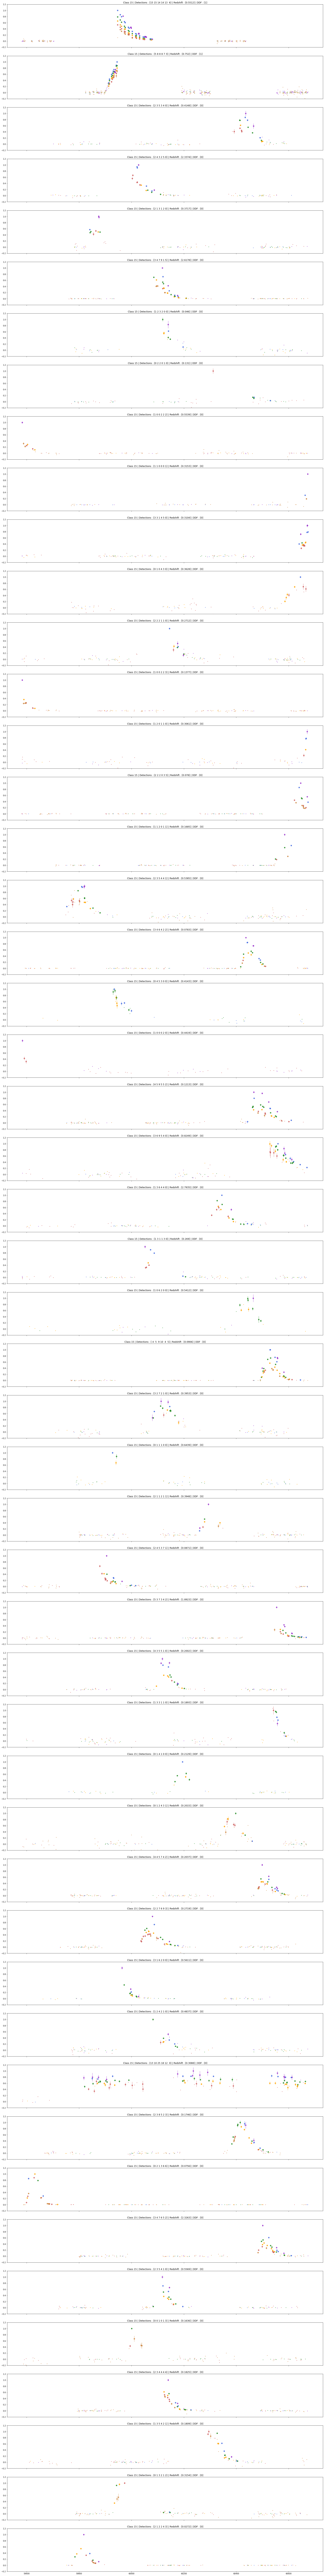

In [141]:
'''
SAMPLE CURVES SAME CLASS
'''

# Select sn class
sn_class = 15

# Select number of curves to plot
N_CURVES = 50

# Plt confs
plt.close('all')
plt.cla()
plt.clf()

f, axs = plt.subplots(N_CURVES, 1, sharex=True, sharey=True, figsize=(30,N_CURVES*5))
colors = ['darkorchid', 'royalblue', 'forestgreen', 'orange', 'indianred', 'peru']

sn_oids = meta.loc[(meta['pred']==15) & (meta['target']==42),'object_id'].values
mask = np.arange(0, len(ts_a))[np.isin(oids_a, sn_oids)]
ts = [ts_a[i] for i in mask]
ms = [ms_a[i] for i in mask]
es = [es_a[i] for i in mask]
ds = [ds_a[i] for i in mask]
oids = oids_a[mask]

for j, (tt, mm, ee, dd, oidd) in enumerate(zip(ts[:N_CURVES], ms[:N_CURVES], es[:N_CURVES], ds[:N_CURVES], oids[:N_CURVES])):

    # Determine scaling factor
    m_max = []
    t_max = []
    for band_num, (t,m,e,d) in enumerate(zip(tt,mm,ee,dd)):

        if np.sum(d) > 0:
            m_max.append(np.max(m[d.astype(bool)]))
            t_max.append(t[d.astype(bool)][np.argmax(m[d.astype(bool)])])

    m_max = np.max(m_max)
    t_max = np.min(t_max)

    det_count = np.zeros(6)
    for band_num, (t,m,e,d) in enumerate(zip(tt,mm,ee,dd)):

        det_count[band_num] = np.sum(d)
        if det_count[band_num] > 0:

            # Detection mask
            s=40
            size_m = np.ones(len(d))*s
            size_m[np.logical_not(d.astype(bool))] *= .1
            
            axs[j].scatter(t, m/m_max, s=size_m, c=colors[band_num], alpha=0.75, marker=None, cmap=None, norm=None, vmin=None, vmax=None)
            axs[j].errorbar(t[d.astype(bool)], m[d.astype(bool)]/m_max, yerr=e[d.astype(bool)]/m_max, fmt='.', c=colors[band_num], alpha=0.6)
    rs = meta.loc[meta['object_id']==oidd,'hostgal_photoz'].values   
    ddf = meta.loc[meta['object_id']==oidd,'ddf'].values   
    axs[j].set_title(f'Class {sn_class} | Detections : {det_count.astype(int)} | Redshift : {rs} | DDF : {ddf}')
    axs[j].set_ylim(-0.2,1.2)
    #axs[j].set_xlim(-50, 300)
f.savefig(f'../edas/pred_15_tgt_42.png')